# Generating synthetic surface densitites using vortensity reconstruction (CR23) or linear evolution (CR24)

This code offers two different ways to estimate the surface density change due to a planet in a protoplanetary disc. The first uses the vortensity reconstruction method from Cimerman and Rafikov 2023 (CR23), `construct_surface_density`, the second uses the much speedier method from Cordwell and Rafikov 2024 `non_local_change_in_density`.

Here we show brief examples of both, including showing why the fitting parameters from Table 1 in Cimerman and Rafikov 2021 (CR21) had to be adjusted.

See CR21 (*Planet-driven density waves in protoplanetary discs: Numerical verification of non-linear evolution theory*), and the first line of figure A1 in CR23 
(*Emergence of vortices at the edges of planet-driven gaps in protoplanetary discs*).

Text(0.5, 1.0, 'Constructed surface densities for a $M_p/M_{th} = 0.25$ planet')

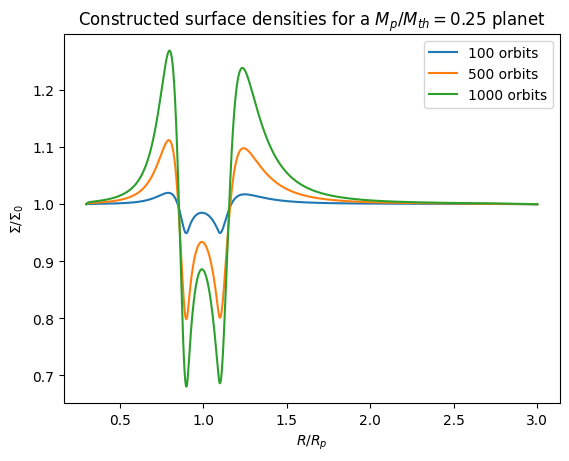

In [1]:
from matplotlib import pyplot as plt
from gap_shape_python.generate_density_profile import construct_surface_density
import numpy as np

orbits = [100, 500, 1000]

m_p = 0.25
p = 1.5
h_p = 0.05


R = np.linspace(0.3, 3, 2000)

for i in range(len(orbits)):
    sigma, error = construct_surface_density(R, p, h_p, m_p, orbits[i])
    plt.plot(R, sigma * R**(p), label='{} orbits'.format(orbits[i]))
    
plt.legend()
plt.xlabel('$R/R_p$')
plt.ylabel('$\Sigma/\Sigma_0$')
plt.title('Constructed surface densities for a $M_p/M_{th} = 0.25$ planet')

# The $2 \pi$ discrepency and passing custom vortensity into the reconstruction algorithm

There was a scaling error in CR21 that caused their overal vortensity (or $f_{dep}$ for CR24) calculation to be off by a factor of $2 \pi$. Here we show the error, as compared to what the reconstructed data should have been (as shown in Figure A1 in CR23), and then show a naieve correction, followed by a correction in the fitting parameters themselves.

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os

# import generate_density_profile
from gap_shape_python.constants import k_b, G
from gap_shape_python.generate_density_profile import (
    compute_delta_zeta, reconstruct_surface_density,
    background_vortensity)

directory = "reference_data/"

files = os.listdir(directory)
models = []

for f in files:
    items = f.split("-")
    models.append(
        {'filename': f,
         'm_p': float(items[1][:-1]),
         'h_p': float(items[2][1:])/100 if float(items[2][1:]) != 1 else 0.1,
         'p': float(items[3].split("_")[0][1:]),
         'time': float(items[3].split("_")[1][1:])
        }
    )

{'filename': 'ISO-0.5M-h05-q1.5_t60_rec_disc.npy', 'm_p': 0.5, 'h_p': 0.05, 'p': 1.5, 'time': 60.0}
p,  1.5
{'filename': 'ISO-0.25M-h1-q1.5_t300_rec_disc.npy', 'm_p': 0.25, 'h_p': 0.1, 'p': 1.5, 'time': 300.0}
p,  1.5
{'filename': 'ISO-0.1M-h05-q1.5_t6800_rec_disc.npy', 'm_p': 0.1, 'h_p': 0.05, 'p': 1.5, 'time': 6800.0}
p,  1.5
{'filename': 'ISO-0.25M-h05-q0_t650_rec_disc.npy', 'm_p': 0.25, 'h_p': 0.05, 'p': 0.0, 'time': 650.0}
p,  0.0


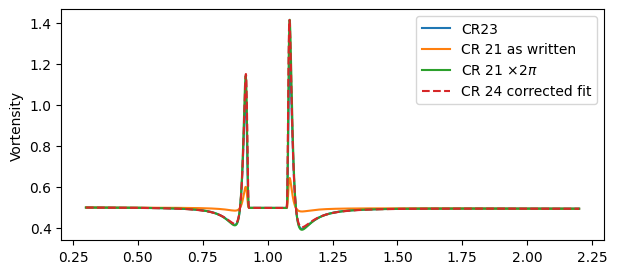

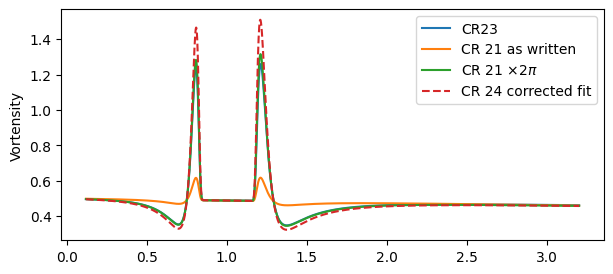

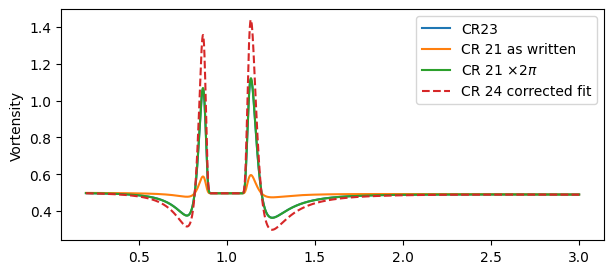

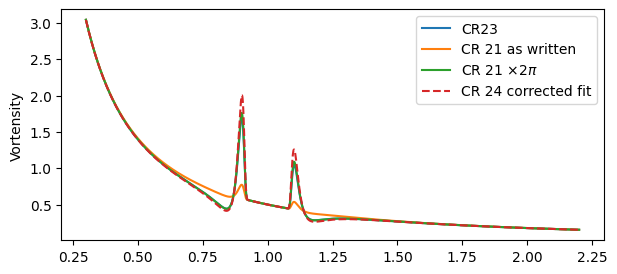

In [3]:
for m in models:
    print(m)
    
    h_p = m['h_p']
    m_p = m['m_p']
    p = m['p']
    
    print("p, ", p)

    R, vortensity, dsigma, domega = np.load(
        directory + m['filename'], allow_pickle=True)

    sigma_0 = R[1:-1]**(-1 * m['p'])
    omega_k = R[1:-1]**(-3/2)

    sigma = sigma_0 * (1 + dsigma[1:-1])
    omega = domega[1:-1] * omega_k
    
    # Attempt calculations 
    del_zeta = compute_delta_zeta(R[1:-1], p, h_p, m_p, use_cr_21=True)
        
    del_zeta_del_t = del_zeta * np.abs(R[1:-1]**(-3/2) - 1)/(2 * np.pi)
    actual_time = m['time'] * 2 * np.pi
    
    # We have to multiply del_zeta by 2pi (not contained in the equations in the paper)
    
    zeta = (background_vortensity(R[1:-1], p, h_p) +
         (del_zeta_del_t * actual_time))
            
    zeta_adjusted = (background_vortensity(R[1:-1], p, h_p) +
         (del_zeta_del_t * actual_time * 2 * np.pi))
    
    zeta_adjusted_2 = (0.5 +
     (del_zeta_del_t * actual_time * 2 * np.pi))
    
    del_zeta = compute_delta_zeta(R[1:-1], p, h_p, m_p, use_cr_21=False)
    
    del_zeta_del_t = del_zeta * np.abs(R[1:-1]**(-3/2) - 1)/(2 * np.pi)
    actual_time = m['time'] * 2 * np.pi

    zeta_adjusted_2 = (background_vortensity(R[1:-1], p, h_p) +
     (del_zeta_del_t * actual_time))

    plt.figure(figsize=(7, 3))
    plt.plot(R[1:-1], vortensity, label="CR23")
    plt.plot(R[1:-1], zeta, label="CR 21 as written")
    plt.plot(R[1:-1], zeta_adjusted, label="CR 21 $ \\times 2 \pi$")
    plt.plot(R[1:-1], zeta_adjusted_2, '--', label="CR 24 corrected fit")

    plt.ylabel("Vortensity")
    plt.legend()


It is clear that the factor of $2 \pi$ is nessecary, and reproduces the work in the paper correctly. In `Corrections to Fitting Parameters.ipynb`, we re-derive the fitting parameters of $\Delta \chi(\tau)$, although we find an additional modification to the mass dependence is required. We have not rederived the vortensity construction equation with that additional dependence.

We now directly compare the surface density reconstructions from the code in this library to the surface densities in Figure A1 of CR23. For simplicity we use only the $2 \pi$ correction factor in the vortensity reconstruciton.

{'filename': 'ISO-0.5M-h05-q1.5_t60_rec_disc.npy', 'm_p': 0.5, 'h_p': 0.05, 'p': 1.5, 'time': 60.0}
p,  1.5
{'filename': 'ISO-0.25M-h1-q1.5_t300_rec_disc.npy', 'm_p': 0.25, 'h_p': 0.1, 'p': 1.5, 'time': 300.0}
p,  1.5
{'filename': 'ISO-0.1M-h05-q1.5_t6800_rec_disc.npy', 'm_p': 0.1, 'h_p': 0.05, 'p': 1.5, 'time': 6800.0}
p,  1.5
{'filename': 'ISO-0.25M-h05-q0_t650_rec_disc.npy', 'm_p': 0.25, 'h_p': 0.05, 'p': 0.0, 'time': 650.0}
p,  0.0


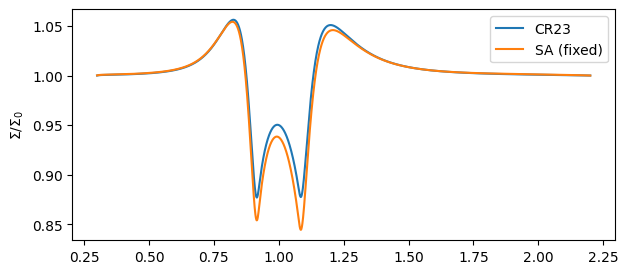

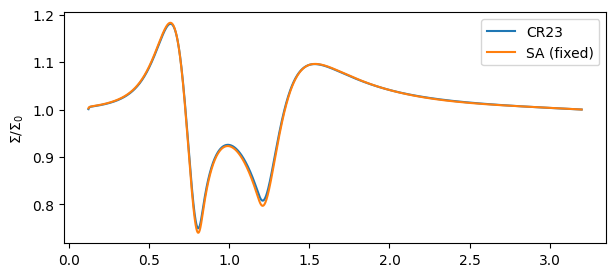

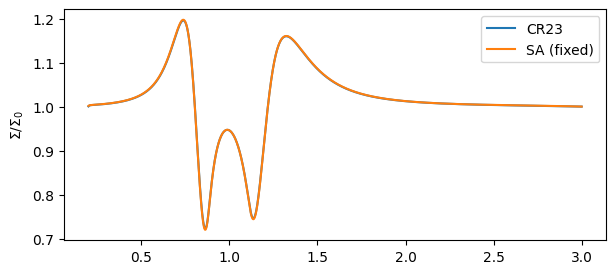

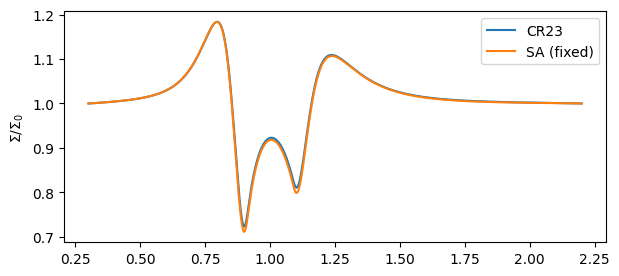

In [4]:
for m in models:
    print(m)
    
    h_p = m['h_p']
    m_p = m['m_p']
    p = m['p']
    
    print("p, ", p)

    R, vortensity, dsigma, domega = np.load(
        directory + m['filename'], allow_pickle=True)

    sigma_0 = R[1:-1]**(-1 * m['p'])
    omega_k = R[1:-1]**(-3/2)

    sigma = sigma_0 * (1 + dsigma[1:-1])
    omega = domega[1:-1] * omega_k
    
    # Attempt calculations 
    sigma_re, error = construct_surface_density(R, p, h_p, m_p, m['time']) 

    plt.figure(figsize=(7, 3))
    plt.plot(R[1:-1], sigma/sigma_0, label="CR23")
    plt.plot(R[1:-1], sigma_re[1:-1]/sigma_0, label="SA (fixed)")

    plt.ylabel("$\Sigma/\Sigma_0$")
    plt.legend()


There are some light deviations - due to the fact we have not implemented the epsilon power dependence in $M_p/M_{th}$ that we discovered would be required.

## Linear Surface Density Evolution

In Cordwell and Rafikov 2024, we provided a linear solution to the evolution of $\sigma = \delta \Sigma/\Sigma_0$. We now briefly show how to apply this solution and compare the estimated surface densities to that provided by the vortensity reconstruction algorithm.

The linear solution is significantly faster than vortensity evolution

--- 0.2238318920135498 seconds for linear model   ---
--- 4.111316919326782 seconds for vortensity model ---


Text(0.5, 1.0, 'Constructed surface densities for a $M_p/M_{th} = 0.25$ planet after 100 orbits')

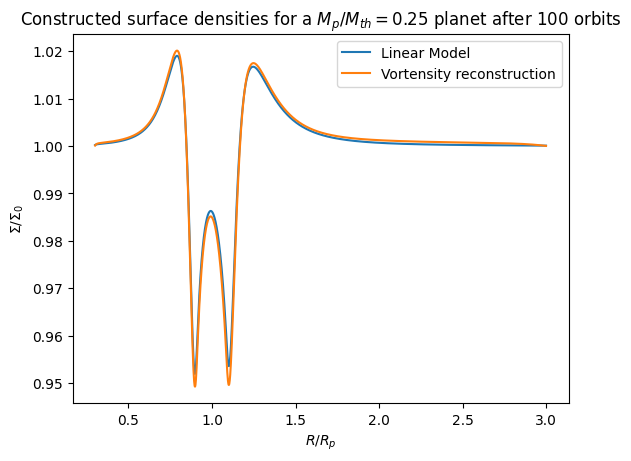

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import time


from gap_shape_python.generate_density_profile import construct_surface_density
from gap_shape_python.analytic_gap_shape import non_local_change_in_density

orbits = 100

m_p = 0.25
p = 1.5
h_p = 0.05


R = np.linspace(0.3, 3, 2000)

start_time = time.time()
dxdt = non_local_change_in_density(R, p, 0, h_p, m_p)
print("--- %s seconds for linear model   ---" % (time.time() - start_time))

plt.plot(R, 1 + dxdt * orbits * 2 * np.pi, label='Linear Model')

start_time = time.time()
sigma_vortensity, error = construct_surface_density(R, p, h_p, m_p, orbits, use_cr_21=True)
print("--- %s seconds for vortensity model ---" % (time.time() - start_time))

plt.plot(R, sigma_vortensity * R**(p), label='Vortensity reconstruction')
    
plt.legend()
plt.xlabel('$R/R_p$')
plt.ylabel('$\Sigma/\Sigma_0$')
plt.title('Constructed surface densities for a $M_p/M_{th} = 0.25$ planet after 100 orbits')